# Imperfect modeling + Sobolev regularization example

This notebook reproduces the experiment from _Convergence and error analysis of PINNs_, Doumèche et al., 2023 [link](https://arxiv.org/pdf/2305.01240.pdf). In particular, the article introduces a _Sobolev regularization_ over the neural network. The original code is [here](https://github.com/NathanDoumeche/Convergence_and_error_analysis_of_PINNs/tree/main/Section_5).

$\Omega = ]0,1[$, $ I=[0, 1]$ and we get observations simulated from the model:

$$
Y = u^*(X) + \mathcal{N}(0, 10^-2), \text{ where } u^*(t, x)=\exp(t - x) + 0.1\cos(2\pi x).
$$

We are in the context of imperfect modeling (_i.e._, there is some modeling error) since we posit an advection model:

$$
\begin{cases}
\frac{\partial u(t,x)}{\partial x} + \frac{\partial u}{\partial t}(t,x)=0\\
u(0, x)=\exp(-x), \forall x\in ]0,1[\\
u(t, 0)=\exp(t),\forall t\in ]0,1[\\
\end{cases}
$$
Since the unique solution of this advection model is $u_{\mathrm{model}}=\exp{(t-x)}\neq u^*$, we are in the imperfect modeling scenario.

In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib inline


Float64 and GPU settings

In [2]:
#import os; os.environ["JAX_ENABLE_X64"] = "TRUE" # comment/uncomment to  disable/enable float64 for JAX
#import os; os.environ["CUDA_VISIBLE_DEVICES"]="" # If uncommented then GPU is disable


Import our package

In [3]:
import jinns


2024-03-07 14:41:43.143762: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Import other dependencies

In [4]:
import jax
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx
from functools import partial
import matplotlib.pyplot as plt

key = random.PRNGKey(2)


## Create observations

In [5]:
def u_star(t, x):
    return jnp.exp(t - x) + 0.1 * jnp.cos(2 * jnp.pi * x)


In [6]:
n = 2000
key, subkey1, subkey2, subkey3 = jax.random.split(key, 4)
t_obs = jax.random.uniform(subkey1, (n, ), minval=0.001, maxval=0.5)
x_obs = jax.random.uniform(subkey2, (n, ), minval=0.001, maxval=1.)
obs = u_star(t_obs, x_obs) + jax.random.normal(subkey3, (n,)) * jnp.sqrt(1e-2)


In [7]:
key, subkey = jax.random.split(key, 2)

obs_data = jinns.data.DataGeneratorObservations(
    subkey,
    obs_batch_size=32 * 32, # n * nt the batch sizes from the collocation point generator
    observed_pinn_in=jnp.stack([t_obs, x_obs], axis=1),
    observed_values=obs
)

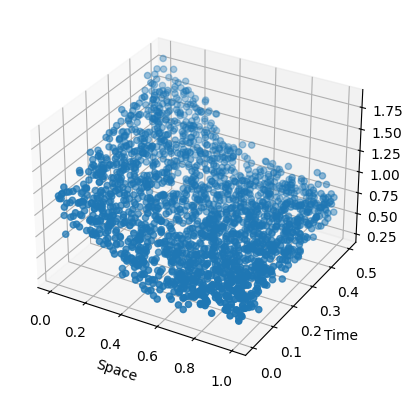

In [8]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x_obs, t_obs, obs)
ax.set_xlabel("Space")
ax.set_ylabel("Time")
#ax.view_init(elev=10., azim=0)
plt.show()

## Visualize $u_{\mathrm{model}}$ and $u^*$

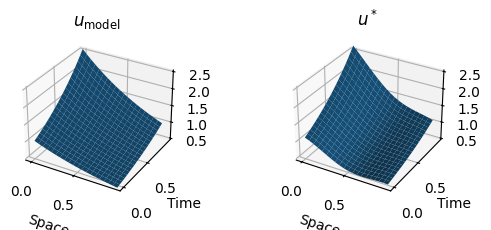

In [9]:
def u_model(t, x):
    return jnp.exp(t - x)

fig = plt.figure()
ax1 = fig.add_subplot(221, projection='3d')
t = x = jnp.arange(0, 1, 0.05)
T, X = jnp.meshgrid(t, x)
zs = jnp.array(u_model(jnp.ravel(T), jnp.ravel(X)))
Z = zs.reshape(X.shape)

ax1.plot_surface(X, T, Z)

ax1.set_xlabel('Space')
ax1.set_ylabel('Time')
ax1.set_zlabel('')
ax1.set_title(r"$u_{\mathrm{model}}$")
ax1.set_zlim((0.5, 2.5))


ax2 = fig.add_subplot(222, projection='3d')

zs = jnp.array(u_star(jnp.ravel(T), jnp.ravel(X)))
Z = zs.reshape(X.shape)

ax2.plot_surface(X, T, Z)

ax2.set_xlabel('Space')
ax2.set_ylabel('Time')
ax2.set_zlabel('')
ax2.set_title(r"$u^*$")
ax2.set_zlim((0.5, 2.5))
plt.show()


Create the neural network architecture for the PINN with `equinox`. Note that we will use the same architecture for the 3 populations.

In [10]:
eqx_list = [
    [eqx.nn.Linear, 2, 50],
    [jax.nn.tanh],
    [eqx.nn.Linear, 50, 50],
    [jax.nn.tanh],
    [eqx.nn.Linear, 50, 50],
    [jax.nn.tanh],
    [eqx.nn.Linear, 50, 50],
    [jax.nn.tanh],
    [eqx.nn.Linear, 50, 1],
]
key, subkey = random.split(key)
u = jinns.utils.create_PINN(subkey, eqx_list, "nonstatio_PDE", 1)

In [11]:
init_nn_params = u.init_params()


Create a DataGenerator object

In [12]:
n = 500
nt = 500
nb = 2
omega_batch_size = 32
temporal_batch_size = 32
omega_border_batch_size = 1
dim = 1
xmin = 0.001
xmax = 1
tmin = 0
tmax = 1
Tmax = 1
method = "uniform"

train_data = jinns.data.CubicMeshPDENonStatio(
    subkey,
    n,
    nb,
    nt,
    omega_batch_size,
    omega_border_batch_size,
    temporal_batch_size,
    dim,
    (xmin,),
    (xmax,),
    tmin,
    tmax,
    method
)


Let's plot the initial condition

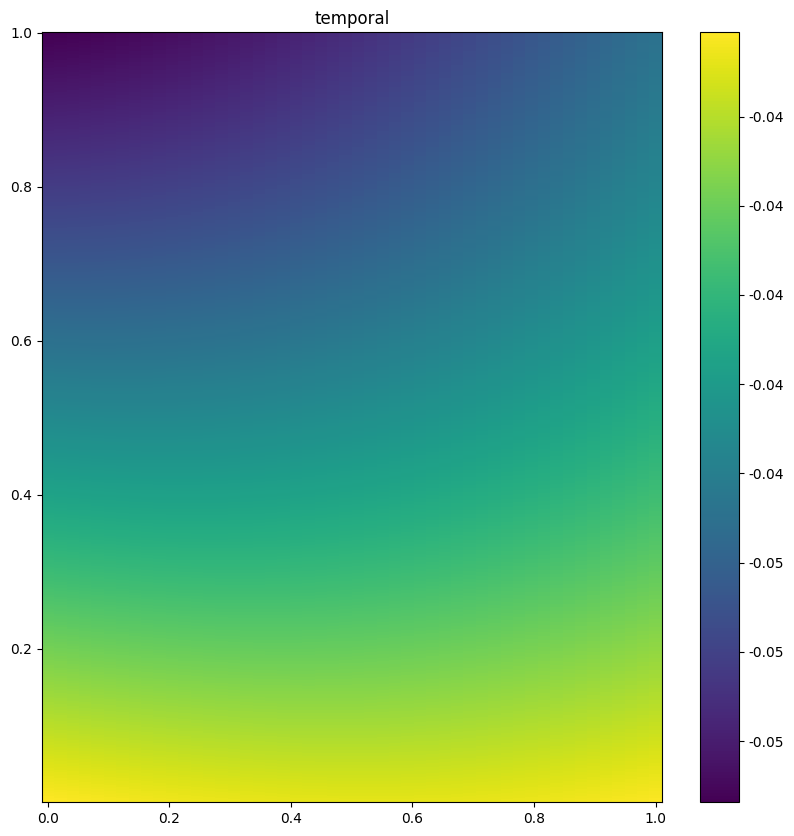

In [13]:
u_init = lambda t, x: u(t, x, init_nn_params)
Tmax = 1
nx = 1000
val_xdata = jnp.linspace(xmin, xmax, nx)
ntime = 50
val_times = jnp.linspace(tmin, tmax, ntime)

jinns.data.plot1d_image(u_init, xdata=val_xdata, times=val_times, cmap="viridis", colorbar=True, figsize=(10,10), title="temporal")


## Model parameters

In [14]:
init_params = {
    "nn_params":init_nn_params,
    "eq_params":{
    }
}


## Initial and boundary conditions

Text(0.5, 1.0, 'Initial condition ($t=0$)')

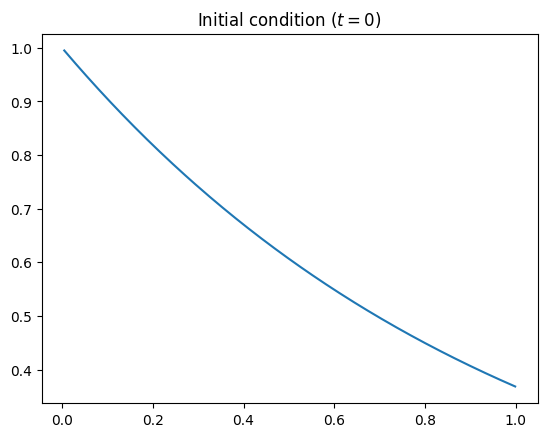

In [15]:
def u_init(x):
    return jnp.exp(-x)

plt.plot(train_data.omega.sort(axis=0), vmap(u_init, (0), 0)(train_data.omega.sort(axis=0)))
plt.title(r"Initial condition ($t=0$)")


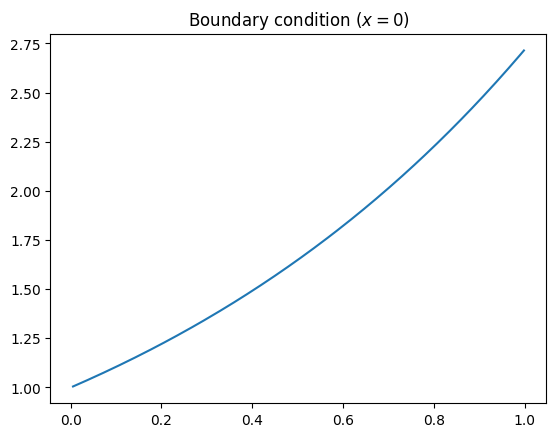

In [16]:
def u_boundary(t, dx):
    return jnp.exp(t)

plt.plot(train_data.omega.sort(axis=0), vmap(u_boundary, (0, None), 0)(train_data.omega.sort(axis=0), None))
plt.title(r"Boundary condition ($x=0$)")

omega_boundary_fun = {
    "xmin": u_boundary,
    "xmax": None
}
omega_boundary_condition = {
    "xmin": "dirichlet",
    "xmax": None
}


## Physics prior: advection equation

In [17]:
from jinns.loss import PDENonStatio

class advection_loss(PDENonStatio):
    def __init__(self, Tmax=1, eq_params_heterogeneity=None):
        super().__init__(Tmax, eq_params_heterogeneity)
    def evaluate(self, t, x, u, params):
        u_ = lambda t, x: u(t, x, params)[0]
        du_dt = jax.grad(u_, 0)
        du_dx = jax.grad(u_, 1)

        return du_dt(t, x) + du_dx(t, x)

dynamic_loss = advection_loss(Tmax=Tmax)


## Learning the neural network parameters without Sobolev regularization

In [18]:
lambda_d = jnp.sqrt(10 * n)
loss_weights = {"dyn_loss":1, "initial_condition":1, "boundary_loss":1, "observations":lambda_d}

loss_no_sobolev = jinns.loss.LossPDENonStatio(
    u=u,
    loss_weights=loss_weights,
    dynamic_loss=dynamic_loss,
    omega_boundary_fun=omega_boundary_fun,
    omega_boundary_condition=omega_boundary_condition,
    initial_condition_fun=u_init
)


In [19]:
params_no_sobolev = init_params
# Optimizer
import optax
lambda_ = 1 / jnp.sqrt(10000)

tx = optax.adamw(learning_rate=1e-3, weight_decay=lambda_)
n_iter = int(30000)


In [20]:
params_no_sobolev, total_loss_list, loss_by_term_dict, train_data, loss_no_sobolev, _, _ = jinns.solve(
    init_params=params_no_sobolev,
    data=train_data,
    optimizer=tx,
    loss=loss_no_sobolev,
    n_iter=n_iter,
    print_loss_every=500,
    obs_data=obs_data
)


Iteration 0: loss value = 62.689605712890625


  0%|          | 0/30000 [00:00<?, ?it/s]

Iteration 500: loss value = 0.8386616706848145
Iteration 1000: loss value = 0.8274749517440796
Iteration 1500: loss value = 0.7927253246307373
Iteration 2000: loss value = 0.8342703580856323
Iteration 2500: loss value = 0.7887061238288879
Iteration 3000: loss value = 0.7606362700462341
Iteration 3500: loss value = 0.7996038794517517
Iteration 4000: loss value = 0.7958081960678101
Iteration 4500: loss value = 0.7723034620285034
Iteration 5000: loss value = 0.7490784525871277
Iteration 5500: loss value = 0.8069950938224792
Iteration 6000: loss value = 0.8092734813690186
Iteration 6500: loss value = 0.7600691318511963
Iteration 7000: loss value = 0.7901931405067444
Iteration 7500: loss value = 0.7191184163093567
Iteration 8000: loss value = 0.7672634720802307
Iteration 8500: loss value = 0.7849743366241455
Iteration 9000: loss value = 0.7345749139785767
Iteration 9500: loss value = 0.8055571913719177
Iteration 10000: loss value = 0.7601028680801392
Iteration 10500: loss value = 0.77897882

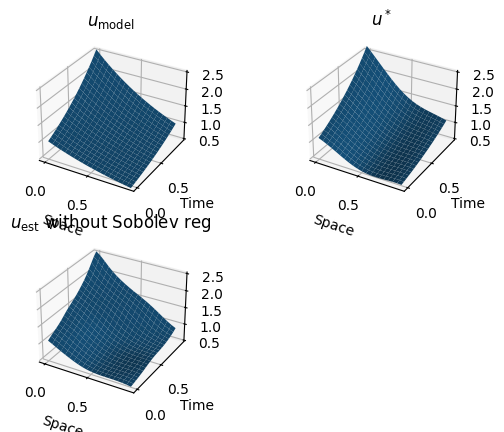

In [21]:
u_est = lambda t, x, p:u(t, x, p)
v_u_est = vmap(u_est, (0, 0, None))
ax3 = fig.add_subplot(223, projection='3d')

zs = jnp.array(v_u_est(jnp.ravel(T)[..., None], jnp.ravel(X)[..., None], params_no_sobolev["nn_params"]))
Z = zs.reshape(X.shape)

ax3.plot_surface(X, T, Z)

ax3.set_xlabel('Space')
ax3.set_ylabel('Time')
ax3.set_zlabel('')
ax3.set_title(r"$u_{\mathrm{est}}$ without Sobolev reg")
ax3.set_zlim((0.5, 2.5))

#ax3.view_init(elev=10., azim=20)

fig


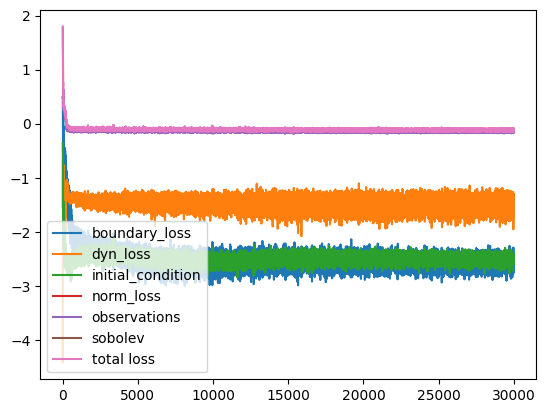

In [22]:
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show();


## Learning the neural network parameters with Sobolev regularization

In [24]:
lambda_t = 0.1 / jnp.log(n)
loss_weights = {"dyn_loss":1, "initial_condition":1, "boundary_loss":1, "observations":lambda_d, "sobolev":lambda_t}

loss_sobolev = jinns.loss.LossPDENonStatio(
    u=u,
    loss_weights=loss_weights,
    dynamic_loss=dynamic_loss,
    omega_boundary_fun=omega_boundary_fun,
    omega_boundary_condition=omega_boundary_condition,
    initial_condition_fun=u_init,
    sobolev_m=1
)


In [25]:
params_sobolev = init_params


In [26]:
# Optimizer
import optax
lambda_ = 1 / jnp.sqrt(10000)

tx = optax.adamw(learning_rate=1e-3, weight_decay=lambda_)


In [27]:
n_iter = int(30000)


In [28]:
params_sobolev, total_loss_list, loss_by_term_dict, train_data, loss_sobolev, _, _ = jinns.solve(
    init_params=params_sobolev,
    data=train_data,
    optimizer=tx,
    loss=loss_sobolev,
    n_iter=n_iter,
    print_loss_every=500,
    obs_data=obs_data
)


Iteration 0: loss value = 63.28007888793945


  0%|          | 0/30000 [00:00<?, ?it/s]

Iteration 500: loss value = 0.9518153071403503
Iteration 1000: loss value = 0.932836651802063
Iteration 1500: loss value = 0.8911406993865967
Iteration 2000: loss value = 0.9457066655158997
Iteration 2500: loss value = 0.8774735927581787
Iteration 3000: loss value = 0.8546972274780273
Iteration 3500: loss value = 0.8996070027351379
Iteration 4000: loss value = 0.8886149525642395
Iteration 4500: loss value = 0.8705891370773315
Iteration 5000: loss value = 0.8533781170845032
Iteration 5500: loss value = 0.9100962281227112
Iteration 6000: loss value = 0.9020975232124329
Iteration 6500: loss value = 0.885748565196991
Iteration 7000: loss value = 0.897042989730835
Iteration 7500: loss value = 0.8323564529418945
Iteration 8000: loss value = 0.8595041632652283
Iteration 8500: loss value = 0.8665987253189087
Iteration 9000: loss value = 0.8271952867507935
Iteration 9500: loss value = 0.8962145447731018
Iteration 10000: loss value = 0.8818038702011108
Iteration 10500: loss value = 0.89220452308

## Results

Plot the loss values

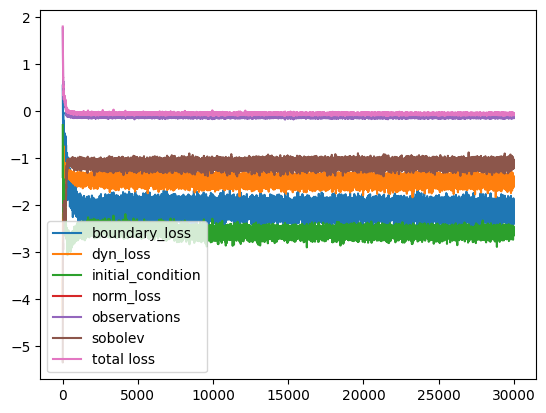

In [29]:
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show();


Plot the ODE solutions learned by the PINN

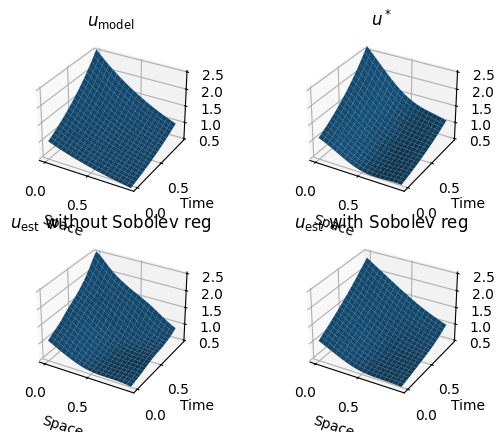

In [30]:
u_est = lambda t, x, p:u(t, x, p)
v_u_est = vmap(u_est, (0, 0, None))
ax4 = fig.add_subplot(224, projection='3d')

zs = jnp.array(v_u_est(jnp.ravel(T)[..., None], jnp.ravel(X)[..., None], params_sobolev["nn_params"]))
Z = zs.reshape(X.shape)

ax4.plot_surface(X, T, Z)

ax4.set_xlabel('Space')
ax4.set_ylabel('Time')
ax4.set_zlabel('')
ax4.set_title(r"$u_{\mathrm{est}}$ with Sobolev reg")
ax4.set_zlim((0.5, 2.5))
fig


## Performance comparison

MSE without Sobolev regularization 0.0044375793
MSE with Sobolev regularization 0.003673486


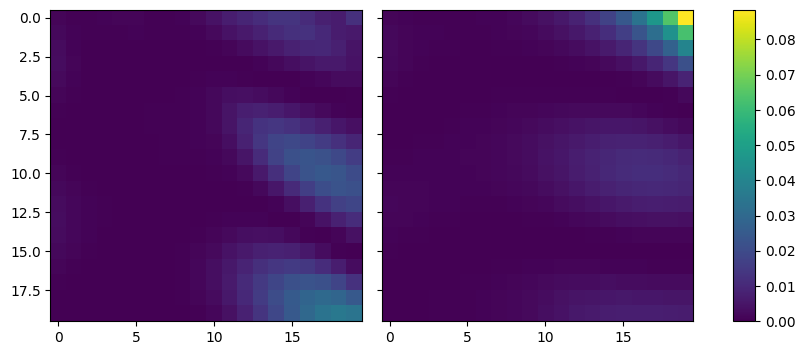

In [31]:
values_no_sobolev = jnp.array(v_u_est(jnp.ravel(T)[..., None], jnp.ravel(X)[..., None], params_no_sobolev["nn_params"]))
values_sobolev = jnp.array(v_u_est(jnp.ravel(T)[..., None], jnp.ravel(X)[..., None], params_sobolev["nn_params"]))
values_true = jnp.array(u_star(jnp.ravel(T), jnp.ravel(X)))

no_sobolev = (values_true - values_no_sobolev.squeeze()) ** 2
sobolev = (values_true - values_sobolev.squeeze()) ** 2
max_error = jnp.amax(jnp.stack([no_sobolev, sobolev]))

print("MSE without Sobolev regularization", jnp.mean(no_sobolev))
print("MSE with Sobolev regularization", jnp.mean(sobolev))

from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(20, 10))
grid = ImageGrid(
    fig,
    122,
    nrows_ncols=(1, 2),
    axes_pad=0.2,
    share_all=True,
    cbar_location="right",
    cbar_mode="single",
    cbar_size="7%",
    cbar_pad=0.4,
)

im = grid[0].imshow(((values_true - values_no_sobolev.squeeze()) ** 2).reshape(X.shape), vmin=0, vmax=max_error)

im = grid[1].imshow(((values_true - values_sobolev.squeeze()) ** 2).reshape(X.shape), vmin=0, vmax=max_error)
grid[1].cax.colorbar(im)

plt.show()


Note: no observation after $t>0.5$.